<a href="https://colab.research.google.com/github/heebaaltaf/good/blob/master/DLGesture_recognition_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [5]:
import numpy as np
import os
import scipy
import imageio
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from PIL import Image, ImageFilter, ImageEnhance
import pathlib
import io


We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
#from google.colab import files
#uploaded = files.upload()

In [9]:
train_doc = np.random.permutation(open('/content/gdrive/My Drive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/My Drive/Project_data/val.csv').readlines())



In [10]:
def hyperparams(batch_size,epochs,n_frames,y,z):
  batch_size=batch_size
  num_epochs=epochs
  
  y=y
  z=z

In [11]:
from imageio import imread

In [12]:
from skimage.transform import resize

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
def batch_data(source_path,t,batch,batch_size):
  
  img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
  x=len(img_idx)
  batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
      
      image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
      if image.shape[1] == 160:
        image = image[:120, 20:140]

                      # resize every image
      image= resize(image, (y,z))

                    
      batch_data[folder,idx,:,:,0] =(image[:,:,0])/255 #normalise and feed in the image
      batch_data[folder,idx,:,:,1] =(image[:,:,1])/255  #normalise and feed in the image
      batch_data[folder,idx,:,:,2] =(image[:,:,2])/255
    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels


In [14]:
def generator(source_path, folder_list, batch_size,y,z,n_frames):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = np.round(np.linspace(0, 29, 3)).astype(int)#create a list of image numbers you want to use for a particular video
    #print(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)//batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield batch_data(source_path, t, batch, batch_size)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield batch_data(source_path, t, batch, batch_size)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Project_data/train'
val_path = '/content/gdrive/My Drive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


# SAMPLE GENERATOR

In [16]:
batch_size=64
n_frames=10
y=100
z=100

In [17]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size,y,z,n_frames)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size,y,z,n_frames)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/gdrive/My Drive/Project_data/train ; batch size = 64
(64, 10, 100, 100, 3)
Source path =  /content/gdrive/My Drive/Project_data/val ; batch size = 64
(64, 10, 100, 100, 3)


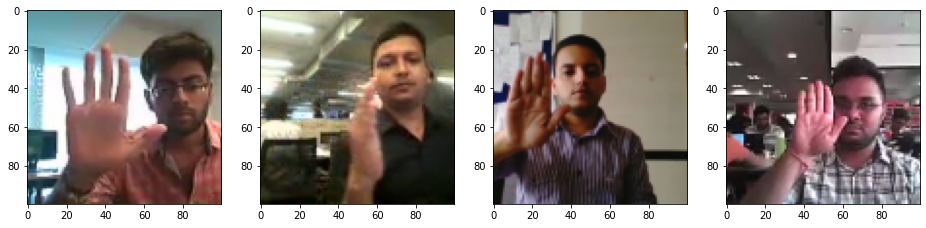

In [20]:
# plot generated sample images
fig, ax = plt.subplots(1,4,figsize=(16,8))
ax[0].imshow(sample_val_batch_data[2,5,:,:,:])   
ax[1].imshow(sample_val_batch_data[1,5,:,:,:])
ax[2].imshow(sample_val_batch_data[3,5,:,:,:])  
ax[3].imshow(sample_val_batch_data[4,5,:,:,:])  
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv2D,Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

CREATE FUNCTIONS FOR

1. BUIDLING MODEL
2. TRAINING MODEL
3.PLOTTING THE RESULTS

In [23]:

def Build3DModel(n_frames,y,z,filter_size=(3,3,3)):
    inputshape = (n_frames,y,z,3)
    model = Sequential()
    model.add(Conv3D(16, filter_size, activation='relu', input_shape=inputshape))
    model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv3D(32, filter_size, activation='relu'))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv3D(64, filter_size, activation='relu'))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [24]:
def train3Dmodel(model):

  train_generator = generator(train_path, train_doc, batch_size,y,z,n_frames)
  val_generator = generator(val_path, val_doc, batch_size,y,z,n_frames)
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq = 'epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

  callbacks_list = [checkpoint, LR]
  #callbacks_list = [LR]
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
  return history


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# EFFECTS OF BATCH SIZE ON NUMBER OF PARAMETERS

In [26]:
#BATCH SIZE 40
batch_size=40
n_frames=16
y=160
z=160
num_epochs=10

model=Build3DModel(n_frames,y,z)
print("Total Params:", model.count_params())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 158, 158, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 79, 79, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 79, 79, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 77, 77, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 5, 39, 39, 32)    0         
 3D)                                                             
                                                        

In [133]:
# Decrease the batchsize to 20
batch_size=20
n_frames=16
y=160
z=160
num_epochs=10

model=Build3DModel(n_frames,y,z)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_63 (Conv3D)          (None, 14, 158, 158, 16)  1312      
                                                                 
 max_pooling3d_63 (MaxPoolin  (None, 7, 79, 79, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_128 (Ba  (None, 7, 79, 79, 16)    64        
 tchNormalization)                                               
                                                                 
 conv3d_64 (Conv3D)          (None, 5, 77, 77, 32)     13856     
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 5, 39, 39, 32)    0         
 g3D)                                                            
                                                     

In [134]:
# decrease batch size to 10
batch_size=10
n_frames=16
y=160
z=160
num_epochs=10

model=Build3DModel(n_frames,y,z)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_66 (Conv3D)          (None, 14, 158, 158, 16)  1312      
                                                                 
 max_pooling3d_66 (MaxPoolin  (None, 7, 79, 79, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_133 (Ba  (None, 7, 79, 79, 16)    64        
 tchNormalization)                                               
                                                                 
 conv3d_67 (Conv3D)          (None, 5, 77, 77, 32)     13856     
                                                                 
 max_pooling3d_67 (MaxPoolin  (None, 5, 39, 39, 32)    0         
 g3D)                                                            
                                                     

We found that batch size did not have any impact on the number of total parameters and hence the memory and time required.

# EFFECT OF NUMBER OF FRAMES ON THE NUMBER OF PARAMETERS

In [135]:
#Increase the number of frames to 30
batch_size=40
n_frames=30
y=160
z=160
num_epochs=10

model=Build3DModel(n_frames,y,z)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_69 (Conv3D)          (None, 28, 158, 158, 16)  1312      
                                                                 
 max_pooling3d_69 (MaxPoolin  (None, 14, 79, 79, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_138 (Ba  (None, 14, 79, 79, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_70 (Conv3D)          (None, 12, 77, 77, 32)    13856     
                                                                 
 max_pooling3d_70 (MaxPoolin  (None, 12, 39, 39, 32)   0         
 g3D)                                                            
                                                     

Increase in number of frames increases the the number of parameters. 

# EFFECT OF IMAGE RESOLUTION ON THE NUMBER OF PARAMETERS

In [136]:
# decrease the image resolution to 100x100
batch_size=40
n_frames=16
y=100
z=100
num_epochs=10

model=Build3DModel(n_frames,y,z)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 14, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_72 (MaxPoolin  (None, 7, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_143 (Ba  (None, 7, 49, 49, 16)    64        
 tchNormalization)                                               
                                                                 
 conv3d_73 (Conv3D)          (None, 5, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_73 (MaxPoolin  (None, 5, 24, 24, 32)    0         
 g3D)                                                            
                                                     

Increase in image resolution also increases the number of parameters.

# **MODEL-1  3DCONV** 
#(n_frames 16,epochs=20,batch_size=64,image_height(y)=100,image_width(z)=100)

In [137]:
batch_size=64
n_frames=16
y=100
z=100
num_epochs=20

model=Build3DModel(n_frames,y,z)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_75 (Conv3D)          (None, 14, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_75 (MaxPoolin  (None, 7, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_148 (Ba  (None, 7, 49, 49, 16)    64        
 tchNormalization)                                               
                                                                 
 conv3d_76 (Conv3D)          (None, 5, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_76 (MaxPoolin  (None, 5, 24, 24, 32)    0         
 g3D)                                                            
                                                     

In [138]:
history=train3Dmodel(model)

Source path =  /content/gdrive/My Drive/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.4333 - categorical_accuracy: 0.4992Source path =  /content/gdrive/My Drive/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-12-2612_26_54.549148/model-00001-1.43332-0.49925-1.90219-0.29000.h5
11/11 [==============================] - 113s 11s/step - loss: 1.4333 - categorical_accuracy: 0.4992 - val_loss: 1.9022 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.8929 - categorical_accuracy: 0.6640
Epoch 00002: saving model to model_init_2021-12-2612_26_54.549148/model-00002-0.89289-0.66403-2.05000-0.15625.h5
11/11 [==============================] - 46s 5s/step - loss: 0.8929 - categorical_accuracy: 0.6640 - val_loss: 2.0500 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.8527 -

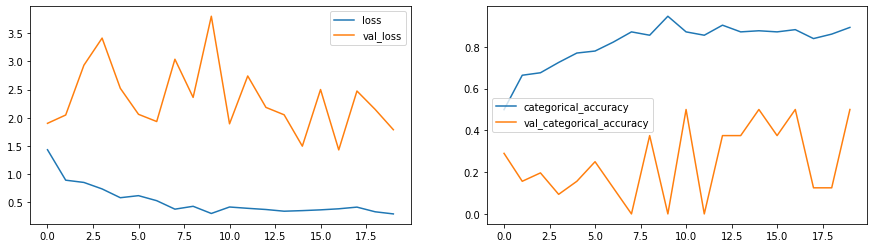

In [139]:
plot(history)

Our first model is clearly overfitting with training accuracy of 0.89 vs validation accuracy of 0.5.

Now lets try to decrease the batchsize to 32.

# **MODEL2**  --**3DCONV** 
#(n_frames 16,epochs=20,batch_size=32,image_height(y)=100,image_width(z)=100)

In [140]:
batch_size=32
n_frames=16
y=100
z=100
num_epochs=20

model2=Build3DModel(n_frames,y,z)
history2=train3Dmodel(model2)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_78 (Conv3D)          (None, 14, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_78 (MaxPoolin  (None, 7, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_153 (Ba  (None, 7, 49, 49, 16)    64        
 tchNormalization)                                               
                                                                 
 conv3d_79 (Conv3D)          (None, 5, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_79 (MaxPoolin  (None, 5, 24, 24, 32)    0         
 g3D)                                                            
                                                     

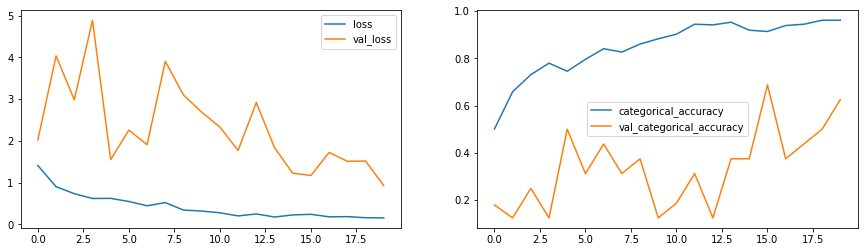

In [141]:
plot(history2)

With decrease in batch size, the training accuracy 0.96 and validation accuracy increased to 0.62 with same number of parameters.


Now lets increase the number of frames to 30 with batch size 32 only.

# **MODEL3**  --**3DCONV** 
#(n_frames 30,epochs=20,batch_size=32,image_height(y)=100,image_width(z)=100)

In [142]:
batch_size=32
n_frames=30
y=100
z=100
num_epochs=20

model3=Build3DModel(n_frames,y,z,filter_size=(2,2,2))
history3=train3Dmodel(model3)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_81 (Conv3D)          (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_81 (MaxPoolin  (None, 14, 49, 49, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_158 (Ba  (None, 14, 49, 49, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_82 (Conv3D)          (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_82 (MaxPoolin  (None, 12, 24, 24, 32)   0         
 g3D)                                                            
                                                     

Increasing the number of frames only increased in the number of parameters without any significant gain in accuracy.

Now, lets keep the batchsize as 32 and number of frames as 20 only and increase the epochs to 40 and change filter size(2,2,2)

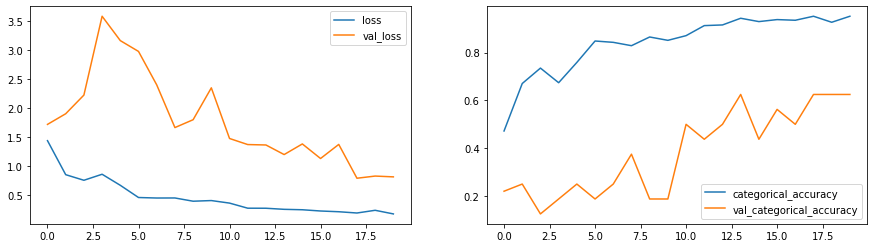

In [143]:
plot(history3)

# **MODEL4**  --**3DCONV** 
#(n_frames 20,epochs=40,batch_size=32,image_height(y)=100,image_width(z)=100)

In [144]:
batch_size=32
n_frames=20
y=100
z=100
num_epochs=40

model4=Build3DModel(n_frames,y,z,filter_size=(2,2,2))
history4=train3Dmodel(model4)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_84 (Conv3D)          (None, 19, 99, 99, 16)    400       
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_163 (Ba  (None, 10, 50, 50, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_85 (Conv3D)          (None, 9, 49, 49, 32)     4128      
                                                                 
 max_pooling3d_85 (MaxPoolin  (None, 9, 25, 25, 32)    0         
 g3D)                                                            
                                                     

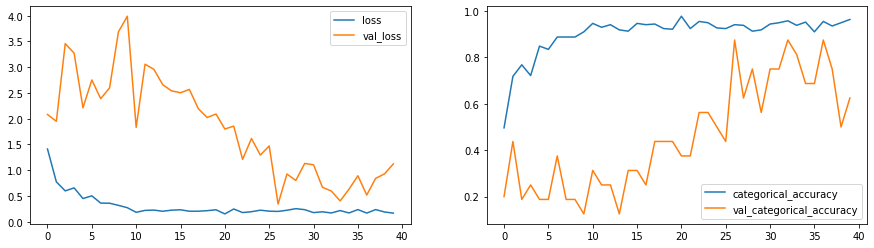

In [145]:
plot(history4)

changing the filter size again didnot improve the valdiction accuracy.

Now let us change the image resolution to 160x160 

# **MODEL5**  --3DCONV 
#(n_frames 20,epochs=20,batch_size=32,image_height(y)=160,image_width(z)=160)

In [147]:
batch_size=32
n_frames=20
y=160
z=160
num_epochs=20

model5=Build3DModel(n_frames,y,z,filter_size=(2,2,2))
history5=train3Dmodel(model5)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_90 (Conv3D)          (None, 19, 159, 159, 16)  400       
                                                                 
 max_pooling3d_90 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_173 (Ba  (None, 10, 80, 80, 16)   64        
 tchNormalization)                                               
                                                                 
 conv3d_91 (Conv3D)          (None, 9, 79, 79, 32)     4128      
                                                                 
 max_pooling3d_91 (MaxPoolin  (None, 9, 40, 40, 32)    0         
 g3D)                                                            
                                                     

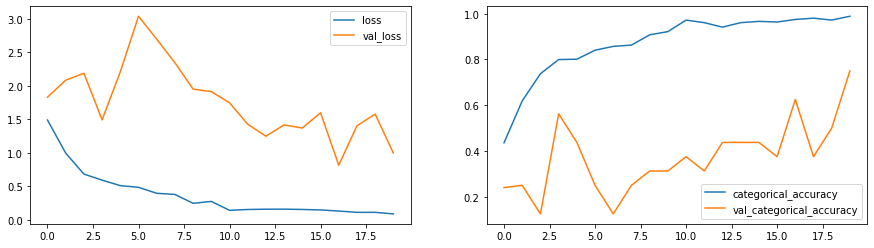

In [148]:
plot(history5)

Adding more layers in the architecture.

# **MODEL6**  --3DCONV 
#(n_frames 20,epochs=20,batch_size=32,image_height(y)=160,image_width(z)=160)

In [154]:
batch_size=32
n_frames=20
y=160
z=160
num_epochs=40
filter_size=(3,3,3)

inputshape=(20,160,160,3)
model6 = Sequential()
model6.add(Conv3D(16, filter_size, activation='relu', input_shape=inputshape))
model6.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model6.add(BatchNormalization())

model6.add(Conv3D(32, filter_size, activation='relu'))
model6.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
model6.add(BatchNormalization())

model6.add(Conv3D(64, filter_size, activation='relu'))
model6.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
model6.add(BatchNormalization())

model6.add(Conv3D(128, filter_size, activation='relu'))
model6.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
model6.add(BatchNormalization())

model6.add(Flatten())
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.25))

model6.add(Dense(64, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.25))

model6.add(Dense(5, activation='softmax'))
#], name="conv_3d2")
model6.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())
    


history6=train3Dmodel(model6)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_97 (Conv3D)          (None, 18, 158, 158, 16)  1312      
                                                                 
 max_pooling3d_97 (MaxPoolin  (None, 9, 79, 79, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_189 (Ba  (None, 9, 79, 79, 16)    64        
 tchNormalization)                                               
                                                                 
 conv3d_98 (Conv3D)          (None, 7, 77, 77, 32)     13856     
                                                                 
 max_pooling3d_98 (MaxPoolin  (None, 7, 39, 39, 32)    0         
 g3D)                                                            
                                                     

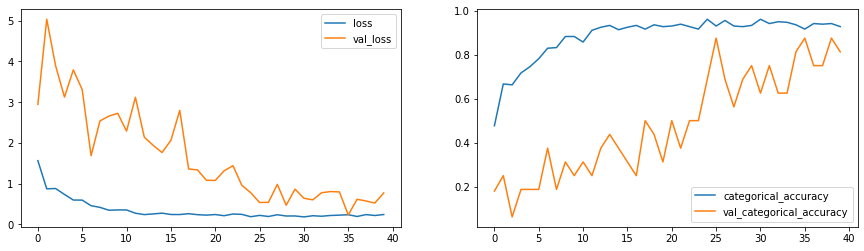

In [155]:
plot(history6)

In [2]:
from keras.layers.recurrent import LSTM

# **2D** **MODEL** **WITH** **LSTM**

In [27]:
def Build2D_LSTM(lstm_cells=64,dense_neurons=64,dropout=0.25):
        inputshape = (n_frames,y,z,3)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print(model.summary())
        return model

In [ ]:
batch_size=32
n_frames=20
y=160
z=160
num_epochs=40

model_LSTM=Build2D_LSTM(lstm_cells=256,dense_neurons=256,dropout=0.25)
historyLSTM=train3Dmodel(model_LSTM)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 160, 160, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 80, 80, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 80, 80, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 80, 80, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 40, 40, 32)  

In [ ]:
  plot(historyLSTM)

In [ ]:
def Build2D_GRU(gru_cells=64,dense_neurons=64,dropout=0.25):
        inputshape = (n_frames,y,z,3)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
       
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))


        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))

        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print(model.summary())
        return model

In [ ]:
batch_size=32
n_frames=20
y=100
z=100
num_epochs=50

model_GRU=Build2D_GRU(gru_cells=256,dense_neurons=256,dropout=0.25)
history_GRU=train3Dmodel(model_GRU)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 20, 50, 50, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 20, 25, 25, 32) 

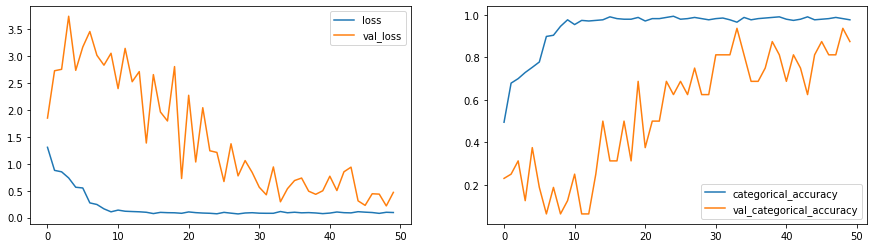

In [ ]:
plot(history_GRU)

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
def BuildtransferGRU_Model(gru_cells=64,dense_neurons=64,dropout=0.25):
  inputshape = (n_frames,y,z,3)
  model = Sequential()
  model.add(TimeDistributed(mobilenet_transfer,input_shape=inputshape))
        
        
  for layer in model.layers:
     layer.trainable = False
        
        
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Flatten()))

  model.add(GRU(gru_cells))
  model.add(Dropout(dropout))
        
  model.add(Dense(dense_neurons,activation='relu'))
  model.add(Dropout(dropout))
        
  model.add(Dense(5, activation='softmax'))
        
        
  optimiser = tf.keras.optimizers.Adam()
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print(model.summary())
  return model

In [ ]:
batch_size=32
n_frames=20
y=224
z=224
num_epochs=20

model_tran_GRU=BuildtransferGRU_Model(gru_cells=256,dense_neurons=256,dropout=0.25)
historytransfer=train3Dmodel(model_tran_GRU)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_73 (TimeDi  (None, 20, 7, 7, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 20, 7, 7, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_75 (TimeDi  (None, 20, 3, 3, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_76 (TimeDi  (None, 20, 9216)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 256)             

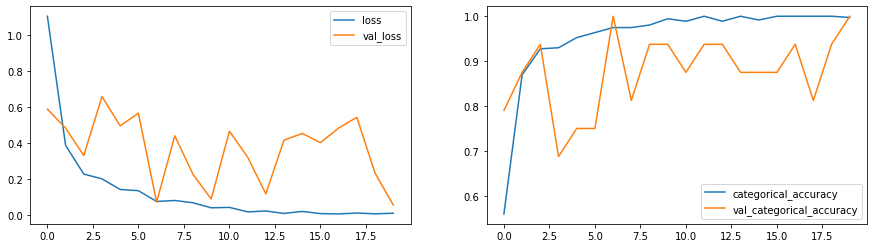

In [ ]:
plot(historytransfer)



> Indented block

